### Load libraries 




In [1]:
import pandas as pd
from IPython import display

import os 
import sys
import time

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import random

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input
from tensorflow.keras.layers import Conv1D, LSTM, Activation
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Flatten, Activation, Permute
from tensorflow.keras.layers import Multiply, Lambda, Reshape, Dot, Concatenate, RepeatVector, TimeDistributed, Permute, Bidirectional
from tensorflow.keras import backend as K

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
pd.__version__

'1.1.3'

In [3]:
os_system = sys.platform
if os_system.startswith('win'):
    os_system = 'windows'
print('OS System: ', os_system)

OS System:  linux


 ### Loading pkl files into DFs

In [4]:
dfList=[]
csvDFList=[]

# Directories are according to git's file structure 
# [Linux] ./gdp-wild-dogs/Data/
if os_system == 'linux':
    filepath = './Data'
    pathstyle = '/'
elif os_system == 'windows':
    filepath = 'Data'
    pathstyle = '\\'

#Store pkl from each day in df in list
for subdir, dirs, files in os.walk(filepath):
    for filename in os.listdir(subdir):
        if filename == "cut.pkl":
            df = pd.read_pickle(subdir+pathstyle+ filename)
            df.reset_index(inplace=True)
            dfList.append(df)
        if filename == "labels.csv":
            df = pd.read_csv(subdir+pathstyle+filename)
            df.reset_index(inplace=True)
            csvDFList.append(df)
print("Number of data files:")
print(len(dfList))

Number of data files:
5


In [5]:
for df in dfList:
    if(len(df["dt"]) > 0):
        print(str(df["dt"][0])[0:10])
        display.display(df.describe())

2020-11-27


,index,seq_counter,ms_counter,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
count,55349.000000,55349.000000,5.534900e+04,55349.000000,55349.000000,55349.000000,5.534900e+04,55349.000000,55349.000000
mean,142475.000000,24.496576,2.855493e+06,-558.998446,-37.440207,-737.303294,2.668183e+03,215.857468,1166.381055
std,15978.024362,14.423795,3.195605e+05,620.526233,603.571494,664.823289,1.108704e+05,78036.689218,101335.105787
min,114801.000000,0.000000,2.302013e+06,-7376.000000,-6487.000000,-7674.000000,-1.060080e+06,-738290.000000,-856170.000000
25%,128638.000000,12.000000,2.578753e+06,-710.000000,-378.000000,-884.000000,-3.766000e+04,-26390.000000,-35280.000000
50%,142475.000000,24.000000,2.855493e+06,-533.000000,-71.000000,-702.000000,3.500000e+02,0.000000,630.000000
75%,156312.000000,37.000000,3.132233e+06,-336.000000,294.000000,-539.000000,4.165000e+04,26040.000000,38150.000000
max,170149.000000,49.000000,3.408973e+06,3887.000000,5791.000000,4210.000000,9.374400e+05,716170.000000,911750.000000


2020-11-26


,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter
count,1.780210e+05,178021.000000,178021.000000,178021.000000,178021.000000,1.780210e+05,178021.000000,1.780210e+05,178021.000000
mean,1.368806e+06,547.496245,28.904230,-390.675387,-2921.359177,-4.615855e+02,1682.975424,2.013806e+06,24.498458
std,5.139038e+04,652.381048,634.201074,611.439068,78737.553151,7.375871e+04,74386.824634,1.575479e+06,14.428949
min,1.279796e+06,-7961.000000,-7923.000000,-7989.000000,-875210.000000,-1.687630e+06,-956970.000000,5.993000e+03,0.000000
25%,1.324301e+06,213.000000,-341.000000,-710.000000,-32340.000000,-2.688000e+04,-29120.000000,9.126530e+05,12.000000
50%,1.368806e+06,561.000000,0.000000,-438.000000,-630.000000,2.100000e+02,910.000000,1.802753e+06,24.000000
75%,1.413311e+06,846.000000,384.000000,-145.000000,28770.000000,2.702000e+04,31150.000000,2.692853e+06,37.000000
max,1.457816e+06,7979.000000,7279.000000,5648.000000,879900.000000,1.828680e+06,808220.000000,7.196216e+06,49.000000


2020-11-16


,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter
count,134699.000000,134699.000000,134699.000000,134699.000000,1.346990e+05,1.346990e+05,134699.000000,1.346990e+05,134699.000000
mean,211600.000000,642.965122,0.948908,-666.393091,5.265697e+02,2.265346e+02,1981.559588,4.237993e+06,24.498274
std,38884.396292,552.142585,534.946670,507.614990,1.046683e+05,7.050509e+04,93278.141436,7.776879e+05,14.425461
min,144251.000000,-6648.000000,-6295.000000,-7421.000000,-1.238860e+06,-1.342670e+06,-858620.000000,2.891013e+06,0.000000
25%,177925.500000,455.000000,-341.000000,-792.000000,-3.780000e+04,-2.408000e+04,-33180.000000,3.564503e+06,12.000000
50%,211600.000000,608.000000,-45.000000,-641.000000,3.500000e+02,-2.800000e+02,1540.000000,4.237993e+06,24.000000
75%,245274.500000,772.000000,303.000000,-512.000000,3.766000e+04,2.254000e+04,35980.000000,4.911483e+06,37.000000
max,278949.000000,7546.000000,6607.000000,5288.000000,1.342320e+06,1.083390e+06,974050.000000,5.584973e+06,49.000000


2020-11-23


,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter
count,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,9.629900e+04,96299.000000
mean,188259.000000,685.967123,184.909885,-585.422839,-2062.369339,-342.111652,1764.676518,4.134299e+07,24.495041
std,27799.271124,394.235820,441.988140,306.318561,66914.127434,57204.250937,62732.408114,5.559854e+05,14.422804
min,140110.000000,-2221.000000,-2775.000000,-5617.000000,-475650.000000,-425810.000000,-480060.000000,4.038001e+07,0.000000
25%,164184.500000,483.000000,-70.000000,-747.000000,-37590.000000,-29890.000000,-32410.000000,4.086150e+07,12.000000
50%,188259.000000,658.000000,227.000000,-572.000000,-2660.000000,-630.000000,280.000000,4.134299e+07,24.000000
75%,212333.500000,859.000000,481.000000,-422.000000,33320.000000,27580.000000,34790.000000,4.182448e+07,37.000000
max,236408.000000,5081.000000,3849.000000,1198.000000,599200.000000,616980.000000,586670.000000,4.230597e+07,49.000000


2020-11-05


,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter
count,5.160300e+04,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000,5.160300e+04,5.160300e+04,51603.000000
mean,1.776850e+06,-593.534077,-282.372672,-607.041606,-1613.547274,-4044.129508,-5.850420e+03,5.655464e+05,24.494913
std,1.489665e+04,924.074716,738.856394,893.257968,133615.227727,106539.700871,1.288504e+05,5.078591e+05,14.426775
min,1.751049e+06,-7994.000000,-7860.000000,-7989.000000,-982590.000000,-714070.000000,-9.460500e+05,5.993000e+03,0.000000
25%,1.763950e+06,-883.000000,-656.000000,-901.000000,-62930.000000,-56280.000000,-5.950000e+04,2.839230e+05,12.000000
50%,1.776850e+06,-499.000000,-339.000000,-525.000000,-70.000000,-3640.000000,-3.360000e+03,5.419330e+05,24.000000
75%,1.789750e+06,-117.000000,67.000000,-132.000000,58170.000000,44380.000000,4.704000e+04,7.999430e+05,37.000000
max,1.802651e+06,4713.000000,7825.000000,4820.000000,912170.000000,814030.000000,1.127840e+06,7.196453e+06,49.000000


In [6]:
for df in csvDFList:
    df.describe()
    print(str(df["start_time"][0])[0:10] + " Labels Loaded")
    print(df.head())
    print()

for df in dfList:
    if(len(df["dt"]) > 0):
        print(str(df["dt"][0])[0:10] + " Clipped Device Data Loaded")
        print(df.head())
        print()

2020-11-27 Labels Loaded
   index                  start_time                    end_time   activity
0      0  2020-11-27 14:09:39.428457  2020-11-27 14:09:42.853634     laying
1      1  2020-11-27 14:09:43.696836  2020-11-27 14:09:46.413592  galloping
2      2  2020-11-27 14:09:49.945660  2020-11-27 14:09:52.640981  galloping
3      3  2020-11-27 14:09:55.582014  2020-11-27 14:09:57.578928   standing
4      4  2020-11-27 14:10:00.794580  2020-11-27 14:10:01.955902  galloping

2020-11-26 Labels Loaded
   index                  start_time                    end_time   activity
0      0  2020-11-26 13:36:46.229766  2020-11-26 13:36:57.575212  galloping
1      1  2020-11-26 13:36:58.259283  2020-11-26 13:37:04.573460   trotting
2      2  2020-11-26 13:37:04.573460  2020-11-26 13:37:15.839838  galloping
3      3  2020-11-26 13:37:17.628225  2020-11-26 13:37:21.307959   trotting
4      4  2020-11-26 13:37:23.889529  2020-11-26 13:37:28.547121    walking

2020-11-16 Labels Loaded
   index   

In [7]:
def label_data(dfList, csvDFList):
    labelledDFList = []
    for dfIndex in range(0, len(dfList)):
        labels = []
        df = dfList[dfIndex]
        if('activity' in df.columns):
            df.drop('activity', 1, inplace=True)
        labelledDFList.append(df)
        csv = csvDFList[dfIndex]
        intervalIndex = 0
        intervalBegin = pd.to_datetime(csv['start_time'][intervalIndex], utc=True)
        intervalEnd = pd.to_datetime(csv['end_time'][intervalIndex], utc=True)
        for i in range(0, len(df)):
            time = pd.to_datetime(df['dt'][i])
            while(time > intervalEnd):
                if(intervalIndex + 1 >= len(csv)):
                    break
                intervalIndex += 1
                intervalBegin = pd.to_datetime(csv['start_time'][intervalIndex], utc=True)
                intervalEnd = pd.to_datetime(csv['end_time'][intervalIndex], utc=True)
            if(time > intervalEnd or time < intervalBegin):
                labels.append("None")
            else:
                labels.append(csv["activity"][intervalIndex])
        labelledDFList[dfIndex]["activity"] = labels
    return labelledDFList

labelledDFList = label_data(dfList, csvDFList)

In [8]:
def concat_df_label_subject(labelledDFList, plot=False):
    # concatenates all data & label subject_id
    
    check_hdc = False
    for idx, df in enumerate(labelledDFList):

        # 2 sessions done for this date (HDC)
        if ((df.dt >= pd.Timestamp("2020-11-26", tz='Europe/London')).unique()[0] and (df.dt < pd.Timestamp("2020-11-27", tz='Europe/London')).unique()[0]) == True:
            check_hdc = True
            df['subject_id'] = df['dt'].apply(lambda x: idx+1 
                                              if x >= pd.Timestamp("2020-11-26 14:10:00", tz='Europe/London') 
                                              else idx)
        else:
            if check_hdc:
                df['subject_id'] = [idx+1] * len(df)
            else:
                df['subject_id'] = [idx] * len(df)

    df_concat = pd.concat(labelledDFList, axis=0)
    
    #Remove unwanted columns and NA values 
    df_concat = df_concat.drop(['seq_counter', 'ms_counter', 'index'], axis=1)
    df_concat = df_concat.replace(to_replace='None', value=np.nan).dropna()
    df_concat = df_concat.dropna(axis=1)
    df_concat = df_concat.reset_index(drop=True)
    
    if plot:
    
        df_concat['activity'].value_counts().plot(kind='bar',title='Data distribution by Activity Type (Full Dataset)')
        plt.show()

        df_concat['subject_id'].value_counts().plot(kind='bar',title='Data distribution by Subject (Full Dataset)')
        plt.show()
    
    return df_concat

In [ ]:
df_concat = concat_df_label_subject(labelledDFList, plot=True)
df_concat

In [ ]:
# df_concat['acc_x'][['activity'] == 'laying'].plot.hist(bins=12, alpha=0.5)
df_concat[df_concat['activity'] == 'walking'].acc_z.plot.hist(bins=12)

# df_concat[df_concat['activity'] == 'jumping'].acc_x.plot.hist(bins=12)
df_concat[df_concat['activity'] == 'walking'].acc_z.value_counts()

In [9]:
 def encode_activities(df_concat):
    
    #Encoding activities 
    activity_dict = dict()
    for i, activity in enumerate(df_concat.activity.unique()):
        activity_dict[activity] = i
#     print('Original Activity Dict')
#     print(activity_dict)
    
    df_concat['activity_encoded'] = df_concat['activity'].apply(lambda x: activity_dict.get(x))
    
    return df_concat, activity_dict

In [ ]:
df_concat, activity_dict = encode_activities(df_concat)
df_concat

In [10]:
def remove_activites(df_concat, activties_to_remove_str, activity_dict, plot=False):
    
    act_remove = activties_to_remove_str
#     print('act_remove', act_remove)
    
    # remove some classes 
    old_activity_dict = activity_dict
    keys = list(old_activity_dict.keys())
    vals = list(old_activity_dict.values())

    activities_to_remove = [ activity_dict.get(i) for i in act_remove ]
    tmp = np.arange(len(activity_dict)).tolist()
    activities_to_REMAIN = [ i for i in tmp if i not in activities_to_remove]
#     print('Activities to Remain')
#     print(activities_to_REMAIN)
    
    # new_activity_dict for new encodings (removed unwanted activities)
    # do that such that its {0,1,2,...} (DL frameworks only likes int starting from 0)
    new_activity_dict = [ activity_dict.pop(i) for i in act_remove]
    for idx, (key, value) in enumerate(activity_dict.items()):
        activity_dict[key] = idx
    new_activity_dict = activity_dict
    print('New Activity Dict after removing')
    print(new_activity_dict)
    
    # trimming df to activities we want to remain 
    df_concat_trim = df_concat[df_concat['activity_encoded'].isin(activities_to_REMAIN)]
    # encode with new encodings 
    df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))
    
    if plot:
        df_concat_trim['activity'].value_counts().plot(kind='bar',title='Data distribution by Activity Type (After Trimming)')
        plt.show()
    
    X_concat_trim = df_concat_trim[["acc_x", "acc_y", "acc_z", "gyro_x" ,"gyro_y" , "gyro_z", "subject_id"]].to_numpy()
    Y_concat_trim = df_concat_trim[["activity_encoded"]].to_numpy()
    
    print('X, Y shape after trimming') 
    print(X_concat_trim.shape, Y_concat_trim.shape)
    
    return df_concat_trim, X_concat_trim, Y_concat_trim

In [ ]:
# Define activites to remove 
# choose activities of lower distribution 
# issue: high class imbalance --> if over or under sample, high bias to data model has seen
activities_to_remove_str = ['jumping', 'standing', 'laying', 'sitting', 'playing', 'sniffing']

df_concat_trim, X_concat_trim, Y_concat_trim = remove_activites(df_concat, activities_to_remove_str, activity_dict, plot=True)
df_concat_trim

In [11]:
def choose_train_test(df_concat_trim, train_subject_id, test_subject_id, axes=6,return_df=False):
    print('%d session(s) in train set ' % (len(train_subject_id)))
    print('%d session(s) in test set ' % (len(test_subject_id)))
    
    axes_cols = None 
    if axes == 6:
        axes_cols = ["acc_x", "acc_y", "acc_z", "gyro_x" ,"gyro_y" , "gyro_z"]
    elif axes == 3:
        axes_cols = ["acc_x", "acc_y", "acc_z"]
    
    
    df_train = df_concat_trim[df_concat_trim['subject_id'].isin(train_subject_id)]
    df_test = df_concat_trim[df_concat_trim['subject_id'].isin(test_subject_id)]  

    X_train = df_train[axes_cols].to_numpy()
    Y_train = df_train[['activity_encoded']].to_numpy()

    X_test = df_test[axes_cols].to_numpy()
    Y_test = df_test[['activity_encoded']].to_numpy()

    print('')
    print('Shape of XY train, XY test')
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    if return_df:
        return X_train, Y_train, X_test, Y_test, df_train, df_test
    else:
        return X_train, Y_train, X_test, Y_test

##### Pre-split Train and Test set

- take sessions from HDC (subject_id == 1,2) as test

In [ ]:
#choose sessions to include in train test split
train_subject_id = [0,3,4,5]
test_subject_id = [1,2]

X_train, Y_train, X_test, Y_test, df_train, df_test = choose_train_test(df_concat_trim,
                                                                        train_subject_id, 
                                                                        test_subject_id,
                                                                        return_df=True)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
print('After train_valid split')
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

In [ ]:
int(17743 * 0.6)

In [12]:
def over_under_sample(X, Y, type_, undersampling=False, oversampling=False, plot=False):
    
    # Find majority class
    majority_class = np.bincount(np.squeeze(Y)).argmax()
    sum_samples_maj = np.bincount(np.squeeze(Y))[np.bincount(np.squeeze(Y)).argmax()]
    
    sampling_strategy_under = None 
    sampling_strategy_over = None 
    if type_ == 'train':
        sampling_strategy_under = { majority_class:40000 }
        sampling_strategy_over = 'all'
    elif type_ == 'valid' or 'test':
        sampling_strategy_under = { majority_class: int(sum_samples_maj*0.2) }
        sampling_strategy_over = 'all'
    
    
    if undersampling:
        # define undersample strategy
        undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_under)
        # fit and apply the transform
        X, Y = undersampler.fit_resample(X, Y)
        
        if plot:
            plt.title('Data distribution after UNDERsampling')
            plt.hist(Y)
            plt.show()
    
    if oversampling:
        oversampler = RandomOverSampler(sampling_strategy=sampling_strategy_over)
        X, Y = oversampler.fit_resample(X, Y)
        if plot:
            plt.title('Data distribution after OVERsampling')
            plt.hist(Y)
            plt.show()

    Y = Y.reshape(len(Y),1)
    print('Shape of XY %s after resampling' %(type_))
    print(X.shape, Y.shape)
    
    return X, Y

    

In [ ]:
X_train, Y_train = over_under_sample(X_train, Y_train, 'train', undersampling=True, oversampling=True, plot=True)
X_valid, Y_valid = over_under_sample(X_valid, Y_valid, 'valid', undersampling=True, oversampling=True, plot=True)

Reshaping Data

In [13]:
# reshapes data into 3D
# batch size of N that belongs in the same class
def reshape_data(X, Y, N=80, axes=6, plot=False):
    
    axes_idx = None 
    if axes == 6:
        axes_idx = [0,1,2,3,4,5]
    elif axes == 3:
        axes_idx = [0,1,2]
    
    data = np.concatenate([X, Y], axis=1)
    
    sliced_list_0 = list()
    for idx, label in enumerate(np.unique(Y)):
            # grouping data of the same label 
            tmp_array_of_same_label = data[data[:,-1] == label, :]
            # (len(tmp_array_of_same_label) // N * N) ensures that 
            # array can be divided into subarrays of length 80 equally
            # OR np.array_split() would return subarrays of unequal length
            tmp_array_of_same_label = tmp_array_of_same_label[:(len(tmp_array_of_same_label) 
                                                                // N * N)]
            
            tmp = len(tmp_array_of_same_label)

            new_length = tmp // N
            tmp_array_slice = np.array(np.array_split(tmp_array_of_same_label, new_length))

            sliced_list_0.append(tmp_array_slice)

    data_sliced = np.concatenate(sliced_list_0, axis=0)
    np.random.shuffle(data_sliced)
    X = data_sliced[:,:,axes_idx]
    Y = data_sliced[:,:,-1][:,0]
    
    # Check distribution of class after reshaping
    if plot:
        plt.title('Class Distribution after Reshaping')
        plt.hist(Y)
        plt.show()
    
    return X, Y



In [ ]:
print('Training data..')
X_train_, Y_train_ = reshape_data(X_train, Y_train ,N=80, axes=6, plot=True)
print('Valid data...')
X_valid_, Y_valid_ = reshape_data(X_valid, Y_valid, N=80, axes=6, plot=True)
print("Testing data..")
X_test_, Y_test_ = reshape_data(X_test, Y_test, N=80, axes=6, plot=True)


In [57]:
def prepare_data(labelledDFList, train_subject_id, test_subject_id, RUS_ROS, axes=6, N=80, plot=False):
    
    
    df_concat = concat_df_label_subject(labelledDFList)
    df_concat, activity_dict = encode_activities(df_concat)
    
    
    #remove activites
    act_remove = ['jumping' ,'standing', 'laying', 'sitting', 'playing', 'sniffing', 'barking']
    df_concat_trim, X_concat_trim, Y_concat_trim = remove_activites(df_concat, 
                                                                    act_remove, 
                                                                    activity_dict)
    
    
    num_class = len(df_concat_trim.activity_encoded.value_counts().unique())
    
    if len(train_subject_id) != 1:
    # Train Test Split by Subjects
    # [0,3,4,5] --> pet dogs 
    # [1,2] --> trained dogs for security
#         train_subject_id = [0,3,4,5]
#         test_subject_id = [1,2]

        X_train, Y_train, X_test, Y_test = choose_train_test(df_concat_trim, 
                                                             train_subject_id, 
                                                             test_subject_id, 
                                                             axes=axes)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, 
                                                              test_size=0.2, 
                                                              random_state=42)
        print('After train_valid split')
        print(X_train.shape, Y_train.shape, 
              X_valid.shape, Y_valid.shape, 
              X_test.shape, Y_test.shape)
   
    elif len(train_subject_id) == 1:
        X_train, X_test, Y_train, Y_test = train_test_split(X_concat_trim, Y_concat_trim, 
                                                            test_size=0.3, 
                                                            random_state=42)
        
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, 
                                                              test_size=0.3, 
                                                              random_state=42)
        
        
        

    if RUS_ROS:
        # Under and Oversampling data 
        X_train, Y_train = over_under_sample(X_train, Y_train, 'train', 
                                             undersampling=True, 
                                             oversampling=True)
        X_valid, Y_valid = over_under_sample(X_valid, Y_valid, 'valid', 
                                             undersampling=True, 
                                             oversampling=True)
        print('After Under and/or Oversampling')
        print(X_train.shape, Y_train.shape, 
              X_valid.shape, Y_valid.shape, 
              X_test.shape, Y_test.shape)
    
    
    # Normalizing data 
    scaler = MinMaxScaler((-1,1))
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.fit_transform(X_valid)
    X_test = scaler.fit_transform(X_test)
    
    
    # Reshape data to batch size N 
    X_train, Y_train = reshape_data(X_train, Y_train, axes=axes, N=N)
    X_valid, Y_valid = reshape_data(X_valid, Y_valid, axes=axes, N=N)
    X_test, Y_test = reshape_data(X_test, Y_test, axes=axes, N=N)
    print('After Reshaping')
    print(X_train.shape, Y_train.shape, 
          X_valid.shape, Y_valid.shape, 
          X_test.shape, Y_test.shape)
    
    
    print('Distribution of data per class')
    unique, counts = np.unique(Y_train, return_counts=True)
    train_dict = dict(zip(unique, counts))
    print(train_dict)
    unique, counts = np.unique(Y_valid, return_counts=True)
    valid_dict = dict(zip(unique, counts))
    print(valid_dict)
    unique, counts = np.unique(Y_test, return_counts=True)
    test_dict = dict(zip(unique, counts))
    print(test_dict)
    if plot:
        plt.title('Class distribution of Train data')
        plt.bar(*zip(*train_dict.items()))
        plt.show()
        
        plt.title('Class distribution of Valid data')
        plt.bar(*zip(*valid_dict.items()))
        plt.show()
        
        plt.title('Class distribution of Test data')
        plt.bar(*zip(*test_dict.items()))
        plt.show()
    
    
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class
  

New Activity Dict after removing
{'galloping': 0, 'trotting': 1, 'walking': 2, 'eating': 3}
X, Y shape after trimming
(203610, 7) (203610, 1)
4 session(s) in train set 
2 session(s) in test set 

Shape of XY train, XY test
(123247, 6) (123247, 1)
(80363, 6) (80363, 1)
After train_valid split
(98597, 6) (98597, 1) (24650, 6) (24650, 1) (80363, 6) (80363, 1)


<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


After Reshaping
(6160, 16, 6) (6160,) (1538, 16, 6) (1538,) (5021, 16, 6) (5021,)
Distribution of data per class
{0.0: 906, 1.0: 754, 2.0: 4430, 3.0: 70}
{0.0: 222, 1.0: 192, 2.0: 1107, 3.0: 17}
{0.0: 545, 1.0: 1456, 2.0: 2430, 3.0: 590}


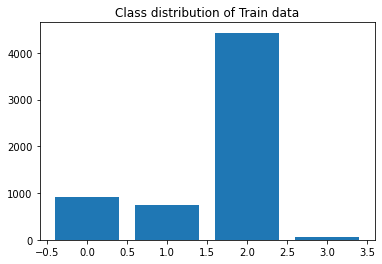

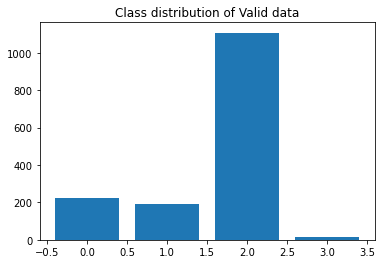

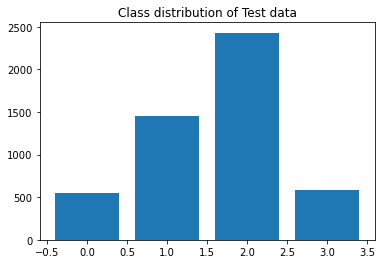

In [63]:
train_subject_id = [0,3,4,5]
test_subject_id = [1,2]


X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class = prepare_data(labelledDFList, 
                                                                             train_subject_id,
                                                                             test_subject_id,
                                                                             False,
                                                                             axes=6, N=16, 
                                                                             plot=True)

In [ ]:
Y_train.shape

In [ ]:
np.unique(Y_train, return_index=True)

In [58]:
def iterate_minibatches(inputs, targets, batchsize):
#     assert len(inputs) == len(targets)
    
#     print(inputs.shape)
    
    while True:
    
        samples_per_class = batchsize // len(np.unique(targets))
        total_samples_per_class = len(inputs) // len(np.unique(targets))
        
        if len(inputs.shape) > 2:
            data = np.concatenate((inputs.reshape(inputs.shape[0], inputs.shape[1]*inputs.shape[2]), targets.reshape(len(targets),1)), axis=1)
#             print('datashape2', data.shape)
            data_tmp = np.empty([batchsize, inputs.shape[1]*inputs.shape[2]+1])
        else:
            data = np.concatenate((inputs, targets.reshape(len(targets),1)), axis=1)
#             print('datashape', data.shape)
            data_tmp = np.empty([batchsize, inputs.shape[1]+1])
        
        indices = np.arange(total_samples_per_class).tolist()
        random.shuffle(indices)
        indices = indices[:samples_per_class]

#         data_tmp = np.empty([batchsize, inputs.shape[1]*inputs.shape[2]+1])
        idx_count = 0
        for label in range(len(np.unique(targets))):
#             print('Label', label)
            tmp_array_of_same_label = data[data[:,-1] == label, :]
#             print(len(tmp_array_of_same_label))
            for idx, index in enumerate(indices):
#                 print(index)
                if index >= len(tmp_array_of_same_label):
                    data_tmp[idx_count] = tmp_array_of_same_label[idx]
                else:
                    data_tmp[idx_count] = tmp_array_of_same_label[index]
                idx_count += 1
        
        np.random.shuffle(data_tmp)
    
        X_tmp = data_tmp[:,:-1]
        if len(inputs.shape) > 2:
            X_tmp = X_tmp.reshape(X_tmp.shape[0], inputs.shape[1], inputs.shape[2])
        Y_tmp = data_tmp[:,-1]
        Y_tmp = Y_tmp.reshape(Y_tmp.shape[0],)
        y_tmp = utils.to_categorical(Y_tmp, len(np.unique(targets)))

#         (unique, counts) = np.unique(Y_tmp, return_counts=True)
#         frequencies = np.asarray((unique, counts)).T
#         print(frequencies)
#         print(X_tmp.shape, y_tmp.shape)
        yield X_tmp, y_tmp

In [59]:
def load_samples(inputs, targets, batchsize):

    # DEFINE GENERATOR TO READ SAMPLES
    iterator = True
    while iterator: 
        try:
            generator = iterate_minibatches(inputs, targets, batchsize)
            x,y = next(generator) 
#             unique, counts = np.unique(y, return_counts=True)
#             print(dict(zip(unique, counts)))
        
        
        except Exception as e:
            print ('the exception: ',e)
            iterator = False 
            print ('end of data generator')
            
#             while iterator:
#                 generator = iterate_minibatches(inputs, targets, batchsize)
#                 x,y = next(generator) 
        
        yield x, y

In [ ]:
train_data = load_samples(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), Y_train, 100)
x, y = next(train_data)
print(x.shape, y.shape)

### Deep Learning Approaches 


#### CNN model
- https://github.com/mohan-mj/Activity-Detection-using-IMU-sensor/blob/master/Human_Activity_Detection-1D%20CNN.ipynb

In [ ]:
def create_CNN_model(x_shape, input_shape,num_class):
    
    # 1D CNN neural network
    model_m = Sequential()
    model_m.add(Reshape((x_shape[1],x_shape[2]), input_shape=(input_shape,)))
    model_m.add(Conv1D(100, 10, activation='relu', input_shape=(x_shape[1],x_shape[2])))
    model_m.add(Conv1D(100, 10, activation='relu'))
    model_m.add(MaxPooling1D(3))
    model_m.add(Dropout(0.3))
    model_m.add(Conv1D(160, 10, activation='relu'))
    model_m.add(Conv1D(160, 10, activation='relu'))
    model_m.add(GlobalAveragePooling1D())
    model_m.add(Dropout(0.3))
    model_m.add(Dense(num_class, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)))
    print(model_m.summary())
    
    return model_m


In [ ]:
def train_CNN(X_train, Y_train, X_valid, Y_valid, num_class, generator=False, BATCH_SIZE=32, EPOCHS=80):
    
    input_shape = X_train.shape[1]*X_train.shape[2]
    print('Input shape:', input_shape)
    
    model = create_CNN_model(X_train.shape, input_shape,num_class)
    
    X_train = X_train.reshape(X_train.shape[0], input_shape)
    Y_train_ = utils.to_categorical(Y_train, num_class)
    print('Train shape:', X_train.shape , Y_train_.shape)
    
    X_valid = X_valid.reshape(X_valid.shape[0], input_shape)
    Y_valid_ = utils.to_categorical(Y_valid, num_class)
    print('Valid shape: ',X_valid.shape , Y_valid_.shape)                                                                           
    
    callbacks_list = [ModelCheckpoint(filepath='model_CNN/best_model.{epoch:02d}-{val_loss:.2f}.h5',
                                     monitor='val_loss', save_best_only=True),
#                       EarlyStopping(monitor='val_accuracy', patience=5), 
                      ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, 
                                        patience=0, min_lr=1e-18, mode='max')]
    
 
    model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    
    start = time.time()
    
    if generator:
        train_gen = load_samples(X_train, Y_train, BATCH_SIZE)
        history = model.fit(train_gen,
                            steps_per_epoch=len(X_train)//BATCH_SIZE,
    #                         batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=callbacks_list,
                            validation_data=(X_valid, Y_valid_),
                            verbose=1)
    else:
        history = model.fit(X_train, Y_train_,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_data=(X_valid, Y_valid_),
                        verbose=1)
        
    end = time.time()
    print('Training took %.4f' % (end-start))
    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

    return model
    

In [17]:
def evaluation_classfication_report(model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class):
    
    y_train = utils.to_categorical(Y_train, num_class)
    print(classification_report(np.argmax(y_train, axis=1), 
                                np.argmax(model.predict(X_train), axis=1), 
#                                 target_names=['galloping', 'standing', 'trotting', 'walking', 'eating']
                               ))
    y_valid = utils.to_categorical(Y_valid, num_class)
    print(classification_report(np.argmax(y_valid, axis=1), 
                                np.argmax(model.predict(X_valid), axis=1), 
#                                 target_names=['galloping', 'standing', 'trotting', 'walking', 'eating']
                               ))
    
    y_test = utils.to_categorical(Y_test, num_class)
    print(classification_report(np.argmax(y_test, axis=1), 
                                np.argmax(model.predict(X_test), axis=1), 
#                                 target_names=['galloping', 'standing', 'trotting', 'walking', 'eating']
                               ))


In [ ]:
model = train_CNN(X_train, Y_train, 
                  X_valid, Y_valid, 
                  num_class, generator=True)
x_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
x_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1]*X_valid.shape[2])
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

evaluation_classfication_report(model, 
                                X_train, Y_train, 
                                x_valid, Y_valid, 
                                x_test, Y_test, 
                                num_class)

### DeepConvLSTM
- https://github.com/felipeagarcia/deepConvLSTM

In [ ]:
class deepConvLSTM(Sequential):
    def __init__(self, num_classes, input_shape, rnn_size=128, num_rnn_layers=2,
                 filter_size=[128, 256, 256], kernel_size=[3,3,3],
                 pool_size=[2,2,2], num_cnn_layers=3, dropout_rate=0.2):
        super().__init__()
        self.num_classes = num_classes
        self.input_data_shape = input_shape
        self.rnn_size = rnn_size
        self.num_rnn_layers = num_rnn_layers
        self.dropout_rate = dropout_rate
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.num_cnn_layers = num_cnn_layers
        self._create_model()

    def _create_model(self):
        self.add(Conv1D(self.filter_size[0], self.kernel_size[0],
                 input_shape=self.input_data_shape))
        self.add(MaxPooling1D(self.pool_size[0]))
        self.add(Activation('relu'))
        for layer in range(1, self.num_cnn_layers):    
            self.add(Conv1D(self.filter_size[layer], self.kernel_size[layer]))
            self.add(MaxPooling1D(self.pool_size[layer]))
            self.add(Activation('relu'))
        self.add(LSTM(self.rnn_size,
                 return_sequences=True))
        for layer in range(1, self.num_rnn_layers):
            self.add(LSTM(self.rnn_size))
        if self.dropout_rate > 0:
            self.add(Dropout(self.dropout_rate))
        self.add(Dense(self.num_classes, activation='softmax'))

In [ ]:
def train_DeepConvLSTM(X_train, Y_train, X_valid, Y_valid, num_class, generator=False, BATCH_SIZE=32, EPOCHS=80):
    
    Y_train_ = utils.to_categorical(Y_train, num_class)
    Y_valid_ = utils.to_categorical(Y_valid, num_class)                                                                  
    
    callbacks_list = [ModelCheckpoint(filepath='model_DeepConvLSTM_ATT/best_model.{epoch:02d}-{val_loss:.2f}.h5',
                                     monitor='val_loss', save_best_only=True),
#                       EarlyStopping(monitor='val_accuracy', patience=5), 
                      ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, 
                                        patience=0, min_lr=1e-18, mode='max')]
    
    

    model = deepConvLSTM(num_class, X_train.shape[1:])
    print(model.summary())

    model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

    start = time.time()
    
    if generator:
        train_gen = load_samples(X_train, Y_train, BATCH_SIZE)
        history = model.fit(train_gen,
                            steps_per_epoch=len(X_train)//BATCH_SIZE,
    #                         batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=callbacks_list,
                            validation_data=(X_valid, Y_valid_),
                            verbose=1)
    else:
        history = model.fit(X_train, Y_train_,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_data=(X_valid, Y_valid_),
                        verbose=1)
        
    end = time.time()
    print('Training took %.4f' % (end-start))
    
    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

    return model

In [ ]:
train_subject_id = [0]
test_subject_id = [0]


X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class = prepare_data(labelledDFList, 
                                                                             train_subject_id,
                                                                             test_subject_id,
                                                                             True,
                                                                             axes=6, N=32, 
                                                                             plot=False)
for i in range(5):
    model_DeepConvLSTM = train_DeepConvLSTM(X_train, Y_train, X_valid, Y_valid, num_class)
    evaluation_classfication_report(model_DeepConvLSTM, 
                                    X_train, Y_train, 
                                    X_valid, Y_valid, 
                                    X_test, Y_test, 
                                    num_class)

### DeepConvLSTM+Attention
- paper: https://arxiv.org/ftp/arxiv/papers/2005/2005.00698.pdf
- github: https://github.com/isukrit/encodingHumanActivity

In [ ]:
class SelfAttention(Layer):
    """
    Layer for implementing self-attention mechanism. Weight variables were preferred over Dense()
    layers in implementation because they allow easier identification of shapes. Softmax activation
    ensures that all weights sum up to 1.
    @param (int) size: a.k.a attention length, number of hidden units to decode the attention before
           the softmax activation and becoming annotation weights
    @param (int) num_hops: number of hops of attention, or number of distinct components to be
           extracted from each sentence.
    @param (bool) use_penalization: set True to use penalization, otherwise set False
    @param (int) penalty_coefficient: the weight of the extra loss
    @param (str) model_api: specify to use TF's Sequential OR Functional API, note that attention
           weights are not outputted with the former as it only accepts single-output layers
    """
    def __init__(self, size, num_hops=8, use_penalization=True,
                 penalty_coefficient=0.1, model_api='functional', batch_size = 1, **kwargs):
        if model_api not in ['sequential', 'functional']:
            raise ValueError("Argument for param @model_api is not recognized")
        self.size = size
        self.num_hops = num_hops
        self.use_penalization = use_penalization
        self.penalty_coefficient = penalty_coefficient
        self.model_api = model_api
        self.batch_size = batch_size
        super(SelfAttention, self).__init__(**kwargs)

    def get_config(self):
        base_config = super(SelfAttention, self).get_config()
        base_config['size'] = self.size
        base_config['batch_size'] = self.batch_size
        base_config['num_hops'] = self.num_hops
        base_config['use_penalization'] = self.use_penalization
        base_config['penalty_coefficient'] = self.penalty_coefficient
        base_config['model_api'] = self.model_api
        return base_config

    def build(self, input_shape):
        self.W1 = self.add_weight(name='W1',
                                  shape=(self.size, int(input_shape[2])),                                # (size, H)
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.W2 = self.add_weight(name='W2',
                                  shape=(self.num_hops, self.size),                                 # (num_hops, size)
                                  initializer='glorot_uniform',
                                  trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):  # (B, S, H)
        # Expand weights to include batch size through implicit broadcasting
        W1, W2 = self.W1[None, :, :], self.W2[None, :, :]
        W1, W2 = tf.tile(W1, [self.batch_size, 1, 1]), tf.tile(W2, [self.batch_size, 1, 1])
        #W1, W2 = tf.compat.v1.repeat(W1, repeats = [self.batch_size], axis=0), tf.compat.v1.repeat(W2, repeats = [self.batch_size], axis=0)
        hidden_states_transposed = Permute(dims=(2, 1))(inputs)                                     # (B, H, S)
        attention_score = tf.matmul(W1, hidden_states_transposed)                                   # (B, size, S)
        attention_score = Activation('tanh')(attention_score)                                       # (B, size, S)
        attention_weights = tf.matmul(W2, attention_score)                                          # (B, num_hops, S)
        attention_weights = Activation('softmax')(attention_weights)                                # (B, num_hops, S)
        embedding_matrix = tf.matmul(attention_weights, inputs)                                     # (B, num_hops, H)
        embedding_matrix_flattened = Flatten()(embedding_matrix)                                    # (B, num_hops*H)

        if self.use_penalization:
            attention_weights_transposed = Permute(dims=(2, 1))(attention_weights)                  # (B, S, num_hops)
            product = tf.matmul(attention_weights, attention_weights_transposed)                    # (B, num_hops, num_hops)
            identity = tf.eye(self.num_hops, batch_shape=(inputs.shape[0],))                        # (B, num_hops, num_hops)
            frobenius_norm = tf.sqrt(tf.reduce_sum(tf.square(product - identity)))  # distance
            self.add_loss(self.penalty_coefficient * frobenius_norm)  # loss

        if self.model_api == 'functional':
            return embedding_matrix_flattened, attention_weights
        elif self.model_api == 'sequential':
            return embedding_matrix_flattened

In [ ]:
def model(x_train, num_labels, LSTM_units, num_conv_filters, batch_size, F, D):
    """
    The proposed model with CNN layer, LSTM RNN layer and self attention layers.
    Inputs:
    - x_train: required for creating input shape for RNN layer in Keras
    - num_labels: number of output classes (int)
    - LSTM_units: number of RNN units (int)
    - num_conv_filters: number of CNN filters (int)
    - batch_size: number of samples to be processed in each batch
    - F: the attention length (int)
    - D: the length of the output (int) 
    Returns
    - model: A Keras model
    """
    cnn_inputs = Input(shape=(x_train.shape[1], x_train.shape[2], 1), batch_size=batch_size, name='rnn_inputs')
    cnn_layer = Conv2D(num_conv_filters, kernel_size = (1, x_train.shape[2]), strides=(1, 1), padding='valid', data_format="channels_last")
    cnn_out = cnn_layer(cnn_inputs)

    sq_layer = Lambda(lambda x: K.squeeze(x, axis = 2))
    sq_layer_out = sq_layer(cnn_out)

    rnn_layer = LSTM(LSTM_units, return_sequences=True, name='lstm', return_state=True) #return_state=True
    rnn_layer_output, _, _ = rnn_layer(sq_layer_out)

    encoder_output, attention_weights = SelfAttention(size=F, num_hops=D, use_penalization=False, batch_size = batch_size)(rnn_layer_output)
    dense_layer = Dense(num_labels, activation = 'softmax')
    dense_layer_output = dense_layer(encoder_output)

    model = Model(inputs=cnn_inputs, outputs=dense_layer_output)
    print(model.summary())

    return model

In [ ]:
Y_train_ = utils.to_categorical(Y_train, num_class)
Y_valid_ = utils.to_categorical(Y_valid, num_class)

rnn_model = model(X_train, num_class, LSTM_units=32,
                num_conv_filters=3, batch_size=16, F=32, D=10)

callbacks = [ModelCheckpoint(filepath='model_DeepConvLSTM_ATT/best_model.{epoch:02d}-{val_loss:.2f}.', 
                             monitor = 'val_acc', save_weights_only=True, save_best_only=True), 
             EarlyStopping(monitor='val_acc', patience=10)]#, LearningRateScheduler()]

opt = Adam(clipnorm=1.)
rnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = rnn_model.fit(X_train, Y_train_, 
                        epochs=10, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=callbacks, 
                        validation_data=(X_valid, Y_valid_))

evaluation_classfication_report(history, 
                                X_train, Y_train, 
                                X_valid, Y_valid, 
                                X_test, Y_test, 
                                num_class)

### Time-CNN model 
- proven succes on small dataset 
- paper: https://arxiv.org/pdf/1809.04356.pdf
- github: https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/cnn.py

In [18]:
class timeCNN(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()
        self.input_data_shape = input_shape
        self.nb_classes = nb_classes
        self.build_model()

        return

    def build_model(self):
        
        padding = 'valid'
        if self.input_data_shape[0] < 60:
            padding = 'same'
            
        self.add(Conv1D(filters=6,kernel_size=7,padding=padding,activation='sigmoid',
                 input_shape=self.input_data_shape))
        self.add(AveragePooling1D(pool_size=3))
        self.add(Conv1D(filters=6,kernel_size=7,padding=padding,activation='sigmoid'))
        self.add(AveragePooling1D(pool_size=3))
        self.add(Flatten())
        self.add(Dense(self.nb_classes, activation='sigmoid'))

In [79]:
def train_TimeCNN(X_train, Y_train, X_valid, Y_valid, num_class, test_scenario, generator=False, BATCH_SIZE=100, EPOCHS=100):
    
    Y_train_ = utils.to_categorical(Y_train, num_class)
    Y_valid_ = utils.to_categorical(Y_valid, num_class)                                                                      
    
    callbacks_list = [ModelCheckpoint(filepath='/best_model'+str(test_scenario)+'.{epoch:02d}-{val_loss:.2f}.h5',
                                     monitor='val_accuracy', save_best_only=True),
                      EarlyStopping(monitor='val_accuracy', patience=10), 
                      ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, 
                                        patience=0, min_lr=1e-18, mode='max')
                     ]

    model = timeCNN(X_train.shape[1:], num_class)
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['accuracy'])

    start = time.time()
    
    if generator:
        train_gen = load_samples(X_train, Y_train, BATCH_SIZE)
        history = model.fit(train_gen,
                            steps_per_epoch=len(X_train)//BATCH_SIZE,
    #                         batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=callbacks_list,
                            validation_data=(X_valid, Y_valid_),
                            verbose=1)
    else:
        history = model.fit(X_train, Y_train_,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_data=(X_valid, Y_valid_),
                        verbose=1)
        
    end = time.time()
    print('Training took %.4f' % (end-start))
    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

    return model

New Activity Dict after removing
{'galloping': 0, 'trotting': 1, 'walking': 2, 'eating': 3}
X, Y shape after trimming
(203610, 7) (203610, 1)
4 session(s) in train set 
2 session(s) in test set 

Shape of XY train, XY test
(123247, 6) (123247, 1)
(80363, 6) (80363, 1)
After train_valid split
(98597, 6) (98597, 1) (24650, 6) (24650, 1) (80363, 6) (80363, 1)


<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


After Reshaping
(3080, 32, 6) (3080,) (768, 32, 6) (768,) (2510, 32, 6) (2510,)
Distribution of data per class
{0.0: 453, 1.0: 377, 2.0: 2215, 3.0: 35}
{0.0: 111, 1.0: 96, 2.0: 553, 3.0: 8}
{0.0: 272, 1.0: 728, 2.0: 1215, 3.0: 295}
Model: "time_cnn_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 32, 6)             258       
_________________________________________________________________
average_pooling1d_96 (Averag (None, 10, 6)             0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 10, 6)             258       
_________________________________________________________________
average_pooling1d_97 (Averag (None, 3, 6)              0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 18)                0         
_____________________

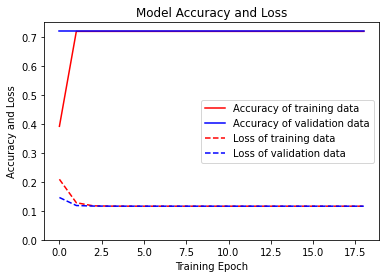

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       453
           1       0.00      0.00      0.00       377
           2       0.72      1.00      0.84      2215
           3       0.00      0.00      0.00        35

    accuracy                           0.72      3080
   macro avg       0.18      0.25      0.21      3080
weighted avg       0.52      0.72      0.60      3080

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00        96
           2       0.72      1.00      0.84       553
           3       0.00      0.00      0.00         8

    accuracy                           0.72       768
   macro avg       0.18      0.25      0.21       768
weighted avg       0.52      0.72      0.60       768

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       272
           1       0.

<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


Model: "time_cnn_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_98 (Conv1D)           (None, 32, 6)             258       
_________________________________________________________________
average_pooling1d_98 (Averag (None, 10, 6)             0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 10, 6)             258       
_________________________________________________________________
average_pooling1d_99 (Averag (None, 3, 6)              0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 18)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 76        
Total params: 592
Trainable params: 592
Non-trainable params: 0
_________________________________________________________

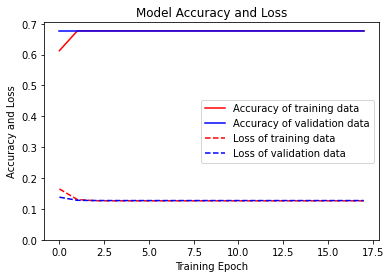

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.00      0.00      0.00       319
           2       0.68      1.00      0.81      1846
           3       0.00      0.00      0.00       124

    accuracy                           0.68      2727
   macro avg       0.17      0.25      0.20      2727
weighted avg       0.46      0.68      0.55      2727

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.00      0.00      0.00        80
           2       0.68      1.00      0.81       459
           3       0.00      0.00      0.00        31

    accuracy                           0.68       680
   macro avg       0.17      0.25      0.20       680
weighted avg       0.46      0.68      0.54       680

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       288
           1       0.

<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


After train_valid split
(138400, 6) (138400, 1) (34600, 6) (34600, 1) (30610, 6) (30610, 1)
After Reshaping
(4323, 32, 6) (4323,) (1079, 32, 6) (1079,) (955, 32, 6) (955,)
Distribution of data per class
{0.0: 352, 1.0: 838, 2.0: 2879, 3.0: 254}
{0.0: 86, 1.0: 207, 2.0: 721, 3.0: 65}
{0.0: 398, 1.0: 155, 2.0: 383, 3.0: 19}
Model: "time_cnn_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 32, 6)             258       
_________________________________________________________________
average_pooling1d_100 (Avera (None, 10, 6)             0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 10, 6)             258       
_________________________________________________________________
average_pooling1d_101 (Avera (None, 3, 6)              0         
_____________________________________________________________

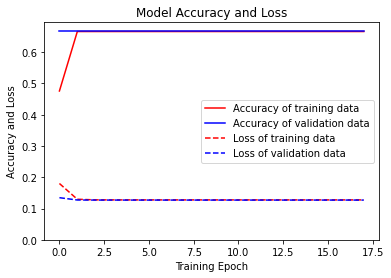

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       352
           1       0.00      0.00      0.00       838
           2       0.67      1.00      0.80      2879
           3       0.00      0.00      0.00       254

    accuracy                           0.67      4323
   macro avg       0.17      0.25      0.20      4323
weighted avg       0.44      0.67      0.53      4323

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.00      0.00      0.00       207
           2       0.67      1.00      0.80       721
           3       0.00      0.00      0.00        65

    accuracy                           0.67      1079
   macro avg       0.17      0.25      0.20      1079
weighted avg       0.45      0.67      0.54      1079

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       398
           1       0.

<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


Model: "time_cnn_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 32, 6)             258       
_________________________________________________________________
average_pooling1d_102 (Avera (None, 10, 6)             0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 10, 6)             258       
_________________________________________________________________
average_pooling1d_103 (Avera (None, 3, 6)              0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 18)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 76        
Total params: 592
Trainable params: 592
Non-trainable params: 0
_________________________________________________________

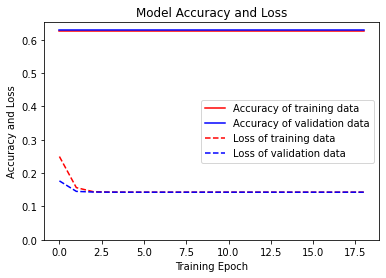

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.00      0.00      0.00       588
           2       0.63      1.00      0.77      1950
           3       0.00      0.00      0.00       166

    accuracy                           0.63      3115
   macro avg       0.16      0.25      0.19      3115
weighted avg       0.39      0.63      0.48      3115

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.00      0.00      0.00       252
           2       0.63      1.00      0.77       838
           3       0.00      0.00      0.00        69

    accuracy                           0.63      1334
   macro avg       0.16      0.25      0.19      1334
weighted avg       0.39      0.63      0.48      1334

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.

In [84]:
train_subject_id = [[0,3,4,5],[0,1,4,5],[1,2,3,4],[0]]
test_subject_id = [[1,2],[2,3],[0,5],[0]]

for test in range(len(train_subject_id)):
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class = prepare_data(labelledDFList, 
                                                                                 train_subject_id[test],
                                                                                 test_subject_id[test],
                                                                                 False,
                                                                                 axes=6, N=32, 
                                                                                 plot=False)
#     for i in range(5):
#         print('Test Scenario: %d // Round %d' % (test, i))
    model_TimeCNN = train_TimeCNN(X_train, Y_train, 
                                  X_valid, Y_valid, 
                                  num_class, test_scenario=test, 
#                                   generator=True,
                                  BATCH_SIZE=32, 
                                  EPOCHS=100)
    evaluation_classfication_report(model_TimeCNN, 
                                    X_train, Y_train, 
                                    X_valid, Y_valid, 
                                    X_test, Y_test, 
                                    num_class)

New Activity Dict after removing
{'galloping': 0, 'trotting': 1, 'walking': 2, 'eating': 3}
X, Y shape after trimming
(203610, 7) (203610, 1)
4 session(s) in train set 
2 session(s) in test set 

Shape of XY train, XY test
(123247, 6) (123247, 1)
(80363, 6) (80363, 1)
After train_valid split
(98597, 6) (98597, 1) (24650, 6) (24650, 1) (80363, 6) (80363, 1)
After Reshaping
(6160, 16, 6) (6160,) (1538, 16, 6) (1538,) (5021, 16, 6) (5021,)
Distribution of data per class
{0.0: 906, 1.0: 754, 2.0: 4430, 3.0: 70}
{0.0: 222, 1.0: 192, 2.0: 1107, 3.0: 17}
{0.0: 545, 1.0: 1456, 2.0: 2430, 3.0: 590}


<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


Model: "time_cnn_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16, 6)             258       
_________________________________________________________________
average_pooling1d_72 (Averag (None, 5, 6)              0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 5, 6)              258       
_________________________________________________________________
average_pooling1d_73 (Averag (None, 1, 6)              0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 6)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 28        
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________

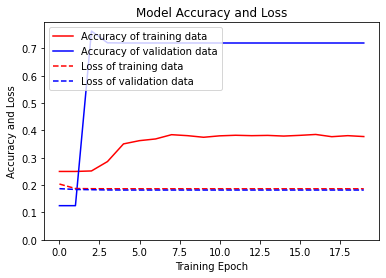

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      0.60      0.72       906
           1       0.12      0.86      0.21       754
           2       0.82      0.04      0.07      4430
           3       0.00      0.00      0.00        70

    accuracy                           0.22      6160
   macro avg       0.46      0.37      0.25      6160
weighted avg       0.73      0.22      0.19      6160

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       222
           1       0.00      0.00      0.00       192
           2       0.73      1.00      0.84      1107
           3       0.00      0.00      0.00        17

    accuracy                           0.72      1538
   macro avg       0.18      0.25      0.21      1538
weighted avg       0.52      0.72      0.61      1538

              precision    recall  f1-score   support

           0       0.15      0.55      0.23       545
           1       0.

<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


Model: "time_cnn_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 16, 6)             258       
_________________________________________________________________
average_pooling1d_74 (Averag (None, 5, 6)              0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 5, 6)              258       
_________________________________________________________________
average_pooling1d_75 (Averag (None, 1, 6)              0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 6)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 28        
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________

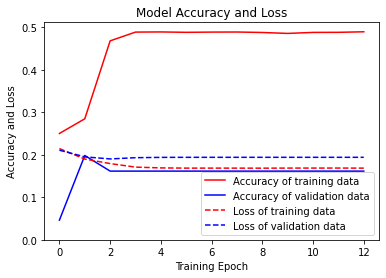

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.62      0.93      0.74       877
           1       0.00      0.00      0.00       638
           2       0.00      0.00      0.00      3693
           3       0.06      1.00      0.11       248

    accuracy                           0.19      5456
   macro avg       0.17      0.48      0.21      5456
weighted avg       0.10      0.19      0.12      5456

              precision    recall  f1-score   support

           0       0.16      1.00      0.28       220
           1       0.00      0.00      0.00       160
           2       0.00      0.00      0.00       919
           3       0.00      0.00      0.00        63

    accuracy                           0.16      1362
   macro avg       0.04      0.25      0.07      1362
weighted avg       0.03      0.16      0.04      1362

              precision    recall  f1-score   support

           0       0.10      0.99      0.18       576
           1       0.

<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


After Reshaping
(8648, 16, 6) (8648,) (2160, 16, 6) (2160,) (1912, 16, 6) (1912,)
Distribution of data per class
{0.0: 704, 1.0: 1677, 2.0: 5758, 3.0: 509}
{0.0: 173, 1.0: 415, 2.0: 1442, 3.0: 130}
{0.0: 796, 1.0: 310, 2.0: 767, 3.0: 39}
Model: "time_cnn_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 16, 6)             258       
_________________________________________________________________
average_pooling1d_76 (Averag (None, 5, 6)              0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5, 6)              258       
_________________________________________________________________
average_pooling1d_77 (Averag (None, 1, 6)              0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 6)                 0         
_______________

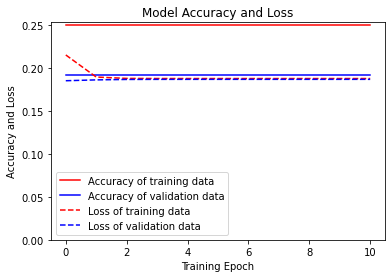

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       704
           1       0.19      1.00      0.32      1677
           2       0.00      0.00      0.00      5758
           3       0.00      0.00      0.00       509

    accuracy                           0.19      8648
   macro avg       0.05      0.25      0.08      8648
weighted avg       0.04      0.19      0.06      8648

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       173
           1       0.19      1.00      0.32       415
           2       0.00      0.00      0.00      1442
           3       0.00      0.00      0.00       130

    accuracy                           0.19      2160
   macro avg       0.05      0.25      0.08      2160
weighted avg       0.04      0.19      0.06      2160

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       796
           1       0.

<ipython-input-10-91273a109c5a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_trim['activity_encoded'] = df_concat_trim['activity'].apply(lambda x: new_activity_dict.get(x))


After Reshaping
(6233, 16, 6) (6233,) (2670, 16, 6) (2670,) (3815, 16, 6) (3815,)
Distribution of data per class
{0.0: 823, 1.0: 1176, 2.0: 3901, 3.0: 333}
{0.0: 350, 1.0: 505, 2.0: 1676, 3.0: 139}
{0.0: 500, 1.0: 720, 2.0: 2390, 3.0: 205}
Model: "time_cnn_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_78 (Conv1D)           (None, 16, 6)             258       
_________________________________________________________________
average_pooling1d_78 (Averag (None, 5, 6)              0         
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 5, 6)              258       
_________________________________________________________________
average_pooling1d_79 (Averag (None, 1, 6)              0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 6)                 0         
_____________

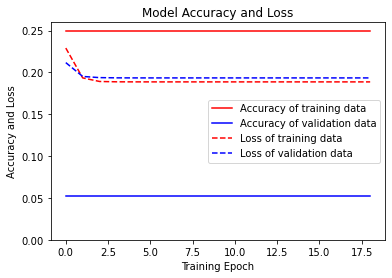

/home/ysk2a15/.conda/envs/gdp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       823
           1       0.00      0.00      0.00      1176
           2       0.00      0.00      0.00      3901
           3       0.05      1.00      0.10       333

    accuracy                           0.05      6233
   macro avg       0.01      0.25      0.03      6233
weighted avg       0.00      0.05      0.01      6233

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       350
           1       0.00      0.00      0.00       505
           2       0.00      0.00      0.00      1676
           3       0.05      1.00      0.10       139

    accuracy                           0.05      2670
   macro avg       0.01      0.25      0.02      2670
weighted avg       0.00      0.05      0.01      2670

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.

In [80]:
train_subject_id = [[0,3,4,5],[0,1,4,5],[1,2,3,4],[0]]
test_subject_id = [[1,2],[2,3],[0,5],[0]]

for test in range(len(train_subject_id)):
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class = prepare_data(labelledDFList, 
                                                                                 train_subject_id[test],
                                                                                 test_subject_id[test],
                                                                                 False,
                                                                                 axes=6, N=16, 
                                                                                 plot=False)
#     for i in range(5):
#         print('Test Scenario: %d // Round %d' % (test, i))
    model_TimeCNN = train_TimeCNN(X_train, Y_train, 
                                  X_valid, Y_valid, 
                                  num_class, test_scenario=test, 
                                  generator=True,
                                  BATCH_SIZE=32, 
                                  EPOCHS=50)
    evaluation_classfication_report(model_TimeCNN, 
                                    X_train, Y_train, 
                                    X_valid, Y_valid, 
                                    X_test, Y_test, 
                                    num_class)

In [75]:
model_test = tf.keras.models.load_model('best_model0.09-0.13.tf')
print(model_test.summary())
evaluation_classfication_report(model_test, 
                                X_train, Y_train, 
                                X_valid, Y_valid, 
                                X_test, Y_test, 
                                4)

KeyError: 'name'

### Pipeline

In [ ]:
def pipeline(labelledDFList, axes=6, N=80, DL='all'):
    
    gen_bool = False
#     RUS_ROS_bool = [False, True]
#     datagen_bool = [False, True]
    
#     train_subject_id = [0]
#     test_subject_id = [0]
    # Prepare data 
#     if split_by_subject:
    train_subject_id = [[0,3,4,5], [0,1,4,5], [1,2,3,4], [0]]
    test_subject_id = [[1,2], [2,3], [0,5], [0]]
    
    # do this to get average results 
    for test_run in range(5):
        for i in range(len(train_subject_id)):
            print('Test Run %d'% (test_run))

    #         for k, rusros_bool in enumerate(RUS_ROS_bool):
#             print('Test Scenario %d'%(i))
    #             print('RUS_ROS: ', rusros_bool)
    #             if len(train_subject_id) == 3:
            X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class = prepare_data(labelledDFList,
                                                                                         train_subject_id[i],
                                                                                         test_subject_id[i], 
                                                                                         True, 
                                                                                         axes=6, N=80)
    #             else:
    #                 #only do traintestsplit, ROS+RUS, normalize, reshape 
    #                 X_train, Y_train, X_valid, Y_valid, X_test, Y_test, num_class = prepare_data(labelledDFList,
    #                                                                                              axes=6, N=80)

            if DL == 'all':

#                 for j, gen_bool in enumerate(datagen_bool):
                print('Test Run %d // Test Scenario %d // Datagen %s // Training on CNN' % (test_run, i, gen_bool))
                model_CNN = train_CNN(X_train, Y_train, X_valid, Y_valid, num_class, generator=gen_bool,
                                      BATCH_SIZE=32, EPOCHS=80)
                evaluation_classfication_report(model_CNN, X_train, Y_train, X_valid, Y_valid, 
                                                X_test, Y_test, num_class)

                print('Test Run %d // Test Scenario %d // Datagen %s // Training on DeepConvLSTM' % (test_run, i,gen_bool))
                model_DeepConvLSTM = train_DeepConvLSTM(X_train, Y_train, X_valid, Y_valid, 
                                                        num_class, generator=gen_bool)
                evaluation_classfication_report(model_DeepConvLSTM, X_train, Y_train, X_valid, Y_valid, 
                                                X_test, Y_test, num_class)

                print('Test Run %d // Test Scenario %d // Datagen %s // Training on Time-CNN' % (test_run, i,gen_bool))
                model_TimeCNN = train_TimeCNN(X_train, Y_train, X_valid, Y_valid, num_class, 
                                              generator=gen_bool, BATCH_SIZE=32, EPOCHS=80)
                evaluation_classfication_report(model_TimeCNN, X_train, Y_train, X_valid, Y_valid, 
                                                X_test, Y_test, num_class)

                    

In [ ]:
pipeline(labelledDFList, axes=6, N=80, DL='all)

### Analysis 

In [ ]:
X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]).shape
Y_train.reshape(len(Y_train), 1).shape

In [ ]:
train_data = np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), 
                             Y_train.reshape(len(Y_train), 1)), axis=1)

train_data = train_data[train_data[:,-1].argsort()][:,:-1]

for class_ in range(5):
    print('Class', class_)
    for i in range(5):
        plt.plot(np.arange(80), train_data[class_*i].reshape(80,6)[:,1])
        plt.show()
        plt.imshow(train_data[class_*i].reshape(80,6))
        plt.show()

In [ ]:
import pywt

scales = np.arange(1, 64+1)
# for samples in 
for signal in range(X_train.shape[2]):
    print('signal', signal)
    for sample in range(1000,1020):
        print('Class:', Y_train[sample])
        coeffs, freqs = pywt.cwt(X_train[sample, :, signal], scales, 'morl') 
        print(coeffs.shape)
        
        fig = plt.figure(figsize=(4,4))
        plt.imshow(coeffs, cmap='coolwarm')
#         plt.spines['right'].set_visible(False)
#         plt.spines['top'].set_visible(False)
#         plt.set_ylabel('Scale')
#         plt.set_xlabel('Time')
        plt.show()
    break
        
            